In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rc('xtick', labelsize = 8) 
matplotlib.rc('ytick', labelsize = 8)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm
import cartopy.feature as cft
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41719,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:40815,Total threads: 4
Dashboard: /proxy/41343/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:38545,


In [4]:
## Loading relevant databases and experiments

db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_control_hh5.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_wind_hh5.db'
session_wind = cc.database.create_session(db)

session = [session_wind, session_cont, session_wind]

expt = ['025deg_jra55_ryf_fluxS_050x_20yr_avg',
        '025deg_jra55_ryf_control',
        '025deg_jra55_ryf_fluxS_150x_20yr_avg']

name = ['0.5xW', 'Control', '1.5xW']

In [5]:
## Loading relevant constants

grav = 9.81
omega = 1/86400
r0 = 6.371 * 10**6

ncoarse = 12
fs = 20 ## Fontsize
rho0 = 1036

In [6]:
start_time = '2299-01-01'
end_time = '2301-12-31'

In [7]:
def var_td(variable, i):
    out = cc.querying.getvar(expt = expt[i], variable = variable, session = session[i], start_time = start_time, end_time = end_time, use_cftime = True)
    out = out.sel(time = slice(start_time, end_time)).mean('time')
    return out

def var_ti(variable, i):
    out = cc.querying.getvar(expt = expt[i], variable = variable, session = session[i], n = 1)
    return out

def var_td(variable, i):
    out = cc.querying.getvar(expt = expt[i], variable = variable, session = session[i], start_time = start_time, end_time = end_time, use_cftime = True)
    out = out.sel(time = slice(start_time, end_time)).mean('time')
    return out

def var_ti(variable, i):
    out = cc.querying.getvar(expt = expt[i], variable = variable, session = session[i], n = 1)
    return out

geolon_t = var_ti('geolon_t', 0)
#geolat_t = var_ti('geolat_t', 0)

# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [8]:
pt_max = 1036

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)
SST = var_td('temp', 1).isel(st_ocean = 0)
land = xr.where(np.isnan(SST.rename('land')), 1, np.nan)
land = land.assign_coords({'geolat_t': geolat_t, 'geolon_t': geolon_t})

In [9]:
x_min = [-70, -250, -70, -220, -70, -250]
x_max = [ 0 , -100,  20, -80 ,  20, -80 ]
y_min = [ 20 ,  20 , -42 ,-37 , -80, -80 ]
y_max = [ 45 ,  75 , -20, -20 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP', 'WG', 'RG']

## 1. Plotting global streamfunction map

In [10]:
def STG_wind(axes):

    expt_wind = ['025deg_jra55_ryf_fluxS_050x_20yr_avg',
                 '025deg_jra55_ryf_control',
                 '025deg_jra55_ryf_fluxS_150x_20yr_avg']
    cmap = ['plum', 'purple' , 'Black']
    for i in np.arange(0, 3, 1):

        variable = xr.open_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/Quantiles_Input/' + basin[k] + '_STG/' + name_save[i] + '.nc')
        variable = variable.to_array().mean('variable')
        variable.sel(percentile = 95, method = 'nearest').plot(label = name_save[i], color = cmap[i], ax = axes)

    plt.grid()

    axes.set_xlabel('Time (years)', fontsize = 20)
    axes.set_ylabel('Transport (Sv)', fontsize = 20)
    axes.set_title('')

In [11]:
# Define the levels for the contourf
lvls = np.linspace(-80, 80, 41)

def psi_func(axes):

    ## Cell-centred x-directed mass transport vertically summed
    tx_trans_int_z = var_td('tx_trans_int_z', 0)
    
    ## 2-dimensional lat-lon grid
    geolon_t = var_ti('geolon_t', 0)
    geolat_t = var_ti('geolat_t', 0)
    
    ## Calculation of streamfunction from x-directed mass transport
    psi = -tx_trans_int_z.cumsum('yt_ocean')/(1e6*rho0) # divide by 1e6 to convert m^3/s -> Sv
    psi_acc = np.nanmin(psi.sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)))
    psi_g = psi - psi_acc
    psi_g = psi_g.rename('psi')
    psi_g.attrs['long_name'] = 'Barotropic Streamfunction'
    psi_g.attrs['units'] = 'Sv'
    psi_g = psi_g.where(~np.isnan(tx_trans_int_z))
    
    ## Interpolating streamfunction to cell centre grid
    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((psi_g, geolat_t))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
    g = xgcm.Grid(data, periodic=['X'])
    psi_g = g.interp(psi_g, 'X')
    psi_g = psi_g.rename('psi')
    
    ## Plotting begins
    
    ## Plotting land and continent boundaries
    axes.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
    axes.gridlines(color = 'grey', linestyle = '--')
    
    ## Plotting global streamfunction
    cf = axes.contourf(psi_g.xt_ocean.values, psi_g.yt_ocean.values, (psi_g * np.sign(psi.yt_ocean)).values, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())
    
    ## Plotting areas referring to Atlantic and Pacific subtropical gyres used for computing time-series
    ax1.add_patch(mpatches.Rectangle(xy=[-100, 20], width=110, height=25, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=1,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-250, 20], width=145, height=25, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=1,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-70, -42], width=90, height=22, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=1,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    #ax1.add_patch(mpatches.Rectangle(xy=[-220, -40], width=140, height=20, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=1,
    #                            fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-190, -47], width=110, height=0.01, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=0.9,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-190, -47], width=0.01, height=7, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=0.9,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-220, -20], width=140, height=0.01, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=0.9,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-80, -47], width=0.01, height=27, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=0.9,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-220, -40], width=30, height=0.01, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=0.9,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    ax1.add_patch(mpatches.Rectangle(xy=[-220, -40], width=0.01, height=20, facecolor=(1,0,0,0), edgecolor=(1,0,0,1), linewidth=0.9,
                                fill=True, zorder=2, transform=ccrs.PlateCarree()))
    
    ## Specifying colorbar attributes
    cbar = fig.colorbar(cf, ax = axes, orientation = 'vertical', shrink = 0.4, ticks = [-80, -40, 0, 40, 80], pad = 0.04)#, aspect = 25, fraction = 0.05)
    cbar.set_label('Transport (Sv)', fontsize = 8)
    cbar.ax.tick_params(labelsize = 8)
    
    return psi_g

Text(0.5, 1.0, '')

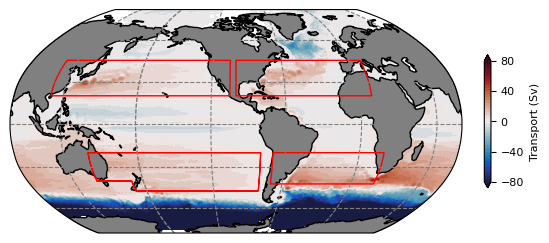

In [12]:
fig, ax1 = plt.subplots(figsize = (6*1.2, 3.6*1.2), subplot_kw = {'projection': ccrs.Robinson(central_longitude = 260)})
psi = psi_func(ax1)
ax1.set_title('')
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Wind_psi_only2_revised.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

# Meridional overturning circulation

## 2. Plotting AMOC, ACC and globally integrated kinetic energy

In [13]:
## x-axis time units
time_val = np.linspace(0 + 2, 95 + 2, 96)

## Colormaps
cmap = ['plum' , 'Black', 'purple']

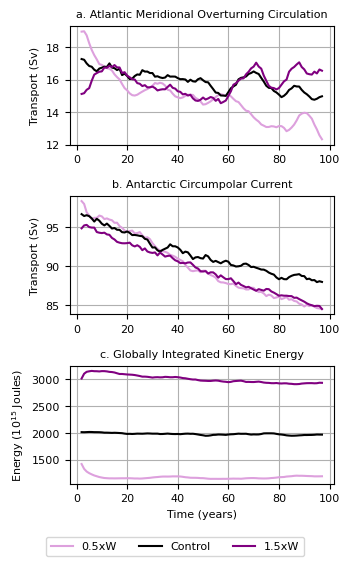

In [14]:
## Start and end model times
st = '2202-01-01'
et = '2301-12-31'

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (3*1.2, 4.5*1.2))

## Looping through the 0.5xW, control and 1.5xW experiments
for i, j in enumerate(session):
    
    ## Plotting AMOC
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = session[i], use_cftime = True, start_time = st, end_time = et).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(st, et))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    axes[0].plot(time_val, psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time"), label = name[i], color = cmap[i])
    axes[0].set_xlabel('', fontsize = 8)
    axes[0].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[0].set_title('a. Atlantic Meridional Overturning Circulation', fontsize = 8)

    ## Plotting DP Transport
    xmin, ymin, ymax = -69.9, -71.6, -51.0
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = session[i], use_cftime = True).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.sel(time = slice(st, et))
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    axes[1].plot(time_val, DP_trans.rolling(time = 5, center = True).mean().dropna("time"), color = cmap[i])
    axes[1].set_xlabel('', fontsize = 8)
    axes[1].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[1].set_title('b. Antarctic Circumpolar Current', fontsize = 8)
    
    ## Plotting globally integrated kinetic energy
    ke = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ke_tot', use_cftime = True)
    ke = ke.sel(time = slice(st, et))
    ke = ke.coarsen({"time": 364}, boundary = "trim").mean()
    axes[2].plot(time_val, ke.rolling(time = 5, center = True).mean().dropna("time"), color = cmap[i])
    axes[2].set_xlabel('Time (years)', fontsize = 8)
    axes[2].set_ylabel('Energy ($10^{15}$ Joules)', fontsize = 8)
    axes[2].set_title('c. Globally Integrated Kinetic Energy', fontsize = 8)
    
axes[0].grid()
axes[1].grid()
axes[2].grid()
    
fig.legend(bbox_to_anchor = (0.5, -0.05), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Wind/MOC_exceptAABW.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 2b. Plotting AMOC and globally integrated kinetic energy

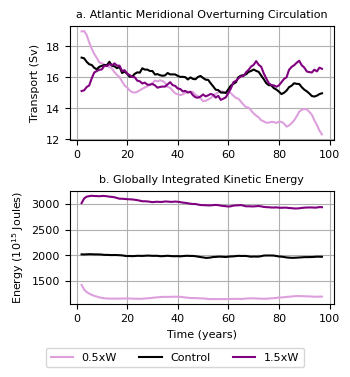

In [15]:
## Start and end model times
st = '2202-01-01'
et = '2301-12-31'

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (3*1.2, 3*1.2))

## Looping through the 0.5xW, control and 1.5xW experiments
for i, j in enumerate(session):
    
    ## Plotting AMOC
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = session[i], use_cftime = True, start_time = st, end_time = et).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(st, et))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    axes[0].plot(time_val, psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time"), label = name[i], color = cmap[i])
    axes[0].set_xlabel('', fontsize = 8)
    axes[0].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[0].set_title('a. Atlantic Meridional Overturning Circulation', fontsize = 8)
    
    ## Plotting globally integrated kinetic energy
    ke = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ke_tot', use_cftime = True)
    ke = ke.sel(time = slice(st, et))
    ke = ke.coarsen({"time": 364}, boundary = "trim").mean()
    axes[1].plot(time_val, ke.rolling(time = 5, center = True).mean().dropna("time"), color = cmap[i])
    axes[1].set_xlabel('Time (years)', fontsize = 8)
    axes[1].set_ylabel('Energy ($10^{15}$ Joules)', fontsize = 8)
    axes[1].set_title('b. Globally Integrated Kinetic Energy', fontsize = 8)
    
axes[0].grid()
axes[1].grid()
    
fig.legend(bbox_to_anchor = (0.5, -0.05), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Wind/AMOC_KE.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 3. Time series for North Atlantic

Text(0.5, 1.0, 'b. North Atlantic')

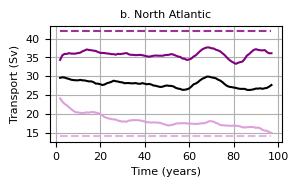

In [ ]:
plt.figure(figsize = (2.5*1.2, 1.25*1.2))

## NETCDF saving 95th percentile (refer to Section 2.2: Gyre Metrics in https://www.navidconstantinou.com/publications/buoyancygyres.pdf) gyre strength
variable = xr.open_dataset('NETCDF/Gyre_95th/NA_STG/psi_iso95_wind_STG.nc')
variable = variable.to_array().mean('variable')

## Plotting time series - looping through 0.5xW, control and 1.5xW experiments
for i in np.arange(0, 3, 1):
    variable.isel(expt = i).plot(label = name[i], color = cmap[i])

## Plotting dotted horizontal pink and purple lines for Sverdrup linear scaling
plt.plot(time_val, 0.5 * (time_val/time_val) * (variable.isel(expt = 1).mean('time')).values, color = 'plum', ls = '--', alpha = 0.8)
plt.plot(time_val, 1.5 * (time_val/time_val) * (variable.isel(expt = 1).mean('time')).values, color = 'purple', ls = '--', alpha = 0.8)

## Plotting attributes
plt.grid()
plt.yticks([15, 20, 25, 30, 35, 40])
plt.xlabel('Time (years)', fontsize = 8)
plt.ylabel('Transport (Sv)', fontsize = 8)
plt.title('b. North Atlantic', fontsize = 8)

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Fig2/NA_STG_wind3.pdf', bbox_inches = 'tight', dpi = 900, transparent=True)

## 4. Time series for North Pacific

Text(0.5, 1.0, 'a. North Pacific')

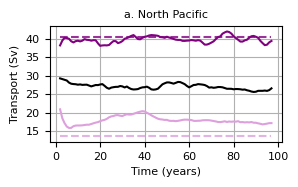

In [ ]:
plt.figure(figsize = (2.5*1.2, 1.25*1.2))

## NETCDF saving 95th percentile (refer to Section 2.2: Gyre Metrics in https://www.navidconstantinou.com/publications/buoyancygyres.pdf) gyre strength
variable = xr.open_dataset('NETCDF/Gyre_95th/NP_STG/psi_iso95_wind_STG.nc')
variable = variable.to_array().mean('variable')

## Plotting time series - looping through 0.5xW, control and 1.5xW experiments
for i in np.arange(0, 3, 1):
    variable.isel(expt = i).plot(label = name[i], color = cmap[i])

## Plotting dotted horizontal pink and purple lines for Sverdrup linear scaling
plt.plot(time_val, 0.5 * (time_val/time_val) * (variable.isel(expt = 1).mean('time')).values, color = 'plum', ls = '--', alpha = 0.8)
plt.plot(time_val, 1.5 * (time_val/time_val) * (variable.isel(expt = 1).mean('time')).values, color = 'purple', ls = '--', alpha = 0.8)

## Plotting attributes
plt.grid()
plt.yticks([15, 20, 25, 30, 35, 40])
plt.xlabel('Time (years)', fontsize = 8)
plt.ylabel('Transport (Sv)', fontsize = 8)
plt.title('a. North Pacific', fontsize = 8)

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Fig2/NP_STG_wind3.pdf', bbox_inches = 'tight', dpi = 900, transparent=True)

## 5. Time series for South Atlantic

Text(0.5, 1.0, 'd. South Atlantic')

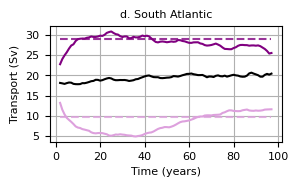

In [ ]:
plt.figure(figsize = (2.5*1.2, 1.25*1.2))

## NETCDF saving 95th percentile (refer to Section 2.2: Gyre Metrics in https://www.navidconstantinou.com/publications/buoyancygyres.pdf) gyre strength
variable = xr.open_dataset('NETCDF/Gyre_95th/SA_STG/psi_iso05_wind.nc')
variable = variable.to_array().mean('variable')

## Plotting time series - looping through 0.5xW, control and 1.5xW experiments
for i in np.arange(0, 3, 1):
    (-1 * variable.isel(expt = i)).plot(label = name[i], color = cmap[i])

## Plotting dotted horizontal pink and purple lines for Sverdrup linear scaling
plt.plot(time_val, 0.5 * (time_val/time_val) * ((-1 * variable.isel(expt = 1)).mean('time')).values, color = 'plum', ls = '--', alpha = 0.8)
plt.plot(time_val, 1.5 * (time_val/time_val) * ((-1 * variable.isel(expt = 1)).mean('time')).values, color = 'purple', ls = '--', alpha = 0.8)

## Plotting attributes
plt.grid()
plt.yticks([5, 10, 15, 20, 25, 30])
plt.xlabel('Time (years)', fontsize = 8)
plt.ylabel('Transport (Sv)', fontsize = 8)
plt.title('d. South Atlantic', fontsize = 8)

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Fig2/SA_STG_wind2.pdf', bbox_inches = 'tight', dpi = 900, transparent=True)

## Time series for South Pacific

Text(0.5, 1.0, 'c. South Pacific')

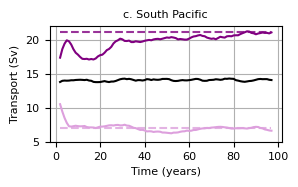

In [ ]:
plt.figure(figsize = (2.5*1.2, 1.25*1.2))

## NETCDF saving 95th percentile (refer to Section 2.2: Gyre Metrics in https://www.navidconstantinou.com/publications/buoyancygyres.pdf) gyre strength
variable = xr.open_dataset('NETCDF/Gyre_95th/SP_STG/psi_iso05_wind.nc')
variable = variable.to_array().mean('variable')

## Plotting time series - looping through 0.5xW, control and 1.5xW experiments
for i in np.arange(0, 3, 1):
    (-1 * variable.isel(expt = i)).plot(label = name[i], color = cmap[i])

## Plotting dotted horizontal pink and purple lines for Sverdrup linear scaling
plt.plot(time_val, 0.5 * (time_val/time_val) * ((-1 * variable.isel(expt = 1)).mean('time')).values, color = 'plum', ls = '--', alpha = 0.8)
plt.plot(time_val, 1.5 * (time_val/time_val) * ((-1 * variable.isel(expt = 1)).mean('time')).values, color = 'purple', ls = '--', alpha = 0.8)

## Plotting attributes
plt.grid()
plt.yticks([5, 10, 15, 20])
plt.xlabel('Time (years)', fontsize = 8)
plt.ylabel('Transport (Sv)', fontsize = 8)
plt.title('c. South Pacific', fontsize = 8)

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Fig2/SP_STG_wind2.pdf', bbox_inches = 'tight', dpi = 900, transparent=True)

## Time series for South Pacific - revision 1

Text(0.5, 1.0, 'c. South Pacific')

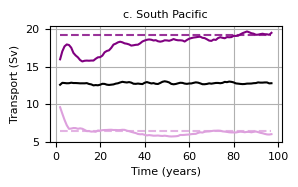

In [ ]:
cmap = ['purple', 'black', 'plum']

plt.figure(figsize = (2.5*1.2, 1.25*1.2))

## NETCDF saving 95th percentile (refer to Section 2.2: Gyre Metrics in https://www.navidconstantinou.com/publications/buoyancygyres.pdf) gyre strength
variable = xr.open_dataset('NETCDF/Gyre_95th/SP_STG/psi_iso95_wind_AUNZ.nc')
variable = variable.to_array().mean('variable')

## Plotting time series - looping through 0.5xW, control and 1.5xW experiments
for i in np.arange(0, 3, 1):
    (-1 * variable.isel(expt = i)).plot(label = name[i], color = cmap[i])

## Plotting dotted horizontal pink and purple lines for Sverdrup linear scaling
plt.plot(time_val, 0.5 * (time_val/time_val) * ((-1 * variable.isel(expt = 1)).mean('time')).values, color = 'plum', ls = '--', alpha = 0.8)
plt.plot(time_val, 1.5 * (time_val/time_val) * ((-1 * variable.isel(expt = 1)).mean('time')).values, color = 'purple', ls = '--', alpha = 0.8)

## Plotting attributes
plt.grid()
plt.yticks([5, 10, 15, 20])
plt.xlabel('Time (years)', fontsize = 8)
plt.ylabel('Transport (Sv)', fontsize = 8)
plt.title('c. South Pacific', fontsize = 8)

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Fig2/SP_STG_wind_revised.pdf', bbox_inches = 'tight', dpi = 900, transparent=True)